Project 4: Advanced Lane Lines

    Part 1: Import required data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

# We load each image manually because we need to know the exact name and associated image
image1 = mpimg.imread('test_images/test1.jpg') 
image2 = mpimg.imread('test_images/test2.jpg') 
image3 = mpimg.imread('test_images/test3.jpg') 
image4 = mpimg.imread('test_images/test4.jpg') 
image5 = mpimg.imread('test_images/test5.jpg') 
image6 = mpimg.imread('test_images/test6.jpg') 
image7 = mpimg.imread('test_images/straight_lines1.jpg') 
image8 = mpimg.imread('test_images/straight_lines2.jpg') 

# Read in all calibration images (images may be in mixed order)
cal_data = np.array([mpimg.imread('camera_cal/' + image) for image in os.listdir('camera_cal')])

    Part 1.5: Visualize input data

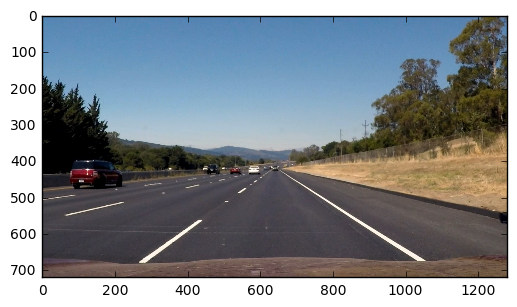

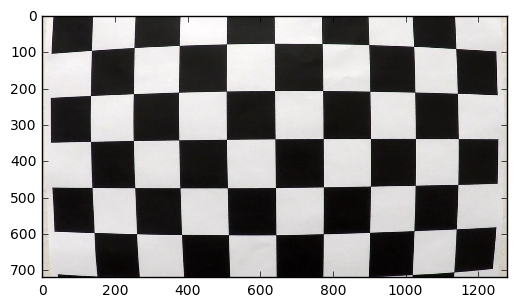

In [2]:
#Test image
plt.imshow(image8)
plt.show()

#Calibration image
plt.imshow(cal_data[3])
plt.show()

    Part 2: Define calibration, correction and perspective transformation functions

In [3]:
def calibrate():

    nx = 9 # number of corners along x axis
    ny = 6 # number of corners along y axis

    objpoints = [] # 3d points in real world 
    imgpoints = [] # 2d points in image

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        
    for image in cal_data: 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720,1280), None, None)
        
    return mtx, dist


def undistort(img, mtx, dist):
    
    return cv2.undistort(img, mtx, dist, None, mtx)


def rotmat(src, dst):
    
    return cv2.getPerspectiveTransform(src,dst)


def unwrap(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

    Part 3: Define selection functions

In [4]:
def hls_select(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_hls=hls[:,:,2]
    binary = np.zeros_like(s_hls)
    binary[(s_hls>thresh[0]) & (s_hls<=thresh[1])] = 1
    return binary

def color_select(img, rthresh=255, gthresh=255):
    y_rgb = img[:,:,2]
    binary = np.zeros_like(y_rgb)
    binary[(img[:,:,0]>rthresh) & (img[:,:,1]>gthresh)] = 1
    return binary
    
def dir_thresh(img, sobel_kernel=3, thresh2=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absx = np.absolute(gx)
    absy = np.absolute(gy)
    mag = np.sqrt(gx*gx+gy*gy)
    dirg = np.arctan2(absy, absx)
    binarymask = np.zeros_like(dirg)
    binarymask [(dirg>thresh2[0]) & (dirg<thresh2[1])] = 1
    return binarymask

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(gx**2+gy**2)
    scale = np.uint8(255*mag/np.max(mag))
    binary = np.zeros_like(scale)
    binary[(scale>mag_thresh[0]) & (scale<mag_thresh[1])] = 1
    return binary

def absx_thresh(img, thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    derx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    absx = np.absolute(derx)
    scale = np.uint8(255*absx/np.max(absx))
    binary_output=np.zeros_like(scale)
    binary_output[(scale > thresh_min) & (scale < thresh_max)]=1
    return binary_output

def absy_thresh(img, thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dery = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absy = np.absolute(dery)
    scale = np.uint8(255*absy/np.max(absy))
    binary_output=np.zeros_like(scale)
    binary_output[(scale > thresh_min) & (scale < thresh_max)]=1
    return binary_output

    Part 4: Run calibration & Test correction

In [7]:
mtx, dist = calibrate()

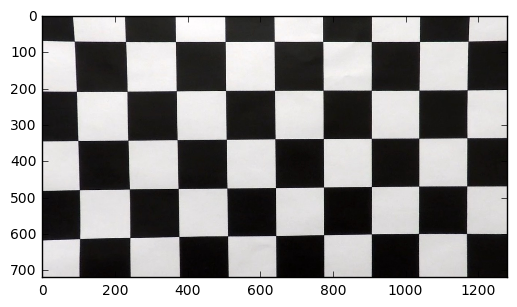

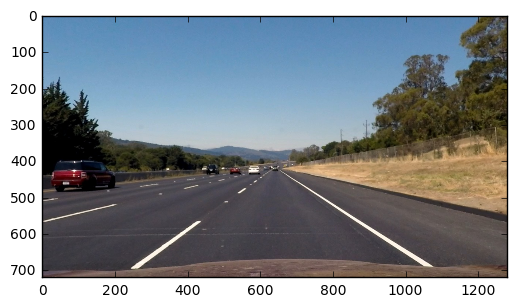

In [8]:
#Test for calibration image
img = cal_data[3]
newimg = undistort(img, mtx, dist)
plt.imshow(newimg)
plt.show()

test = mpimg.imread('test.jpg')
#Test for real image
image8c = undistort(image8, mtx, dist)
plt.imshow(image8c)
plt.show()

    Part 5: Test selection

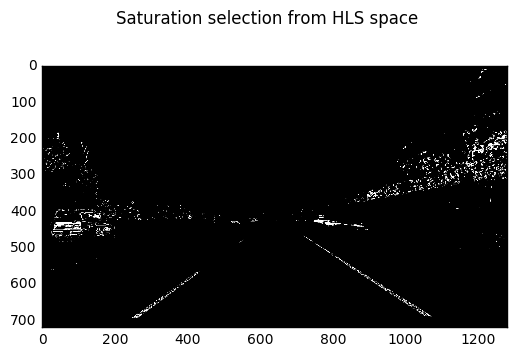

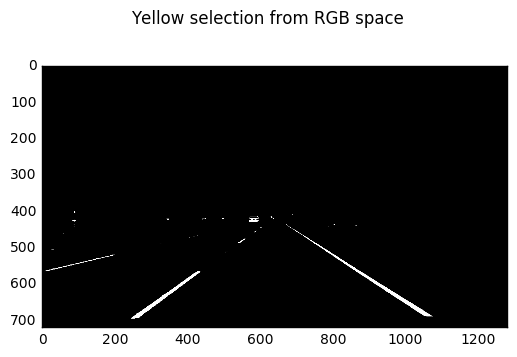

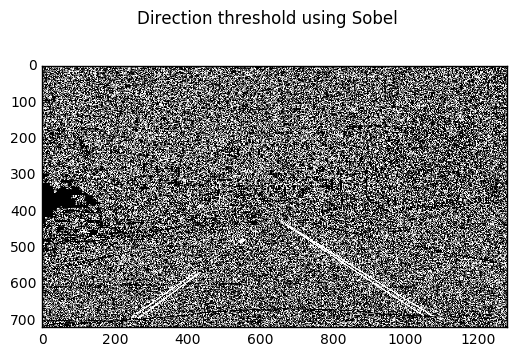

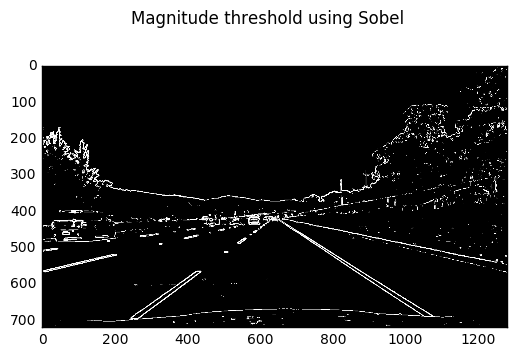

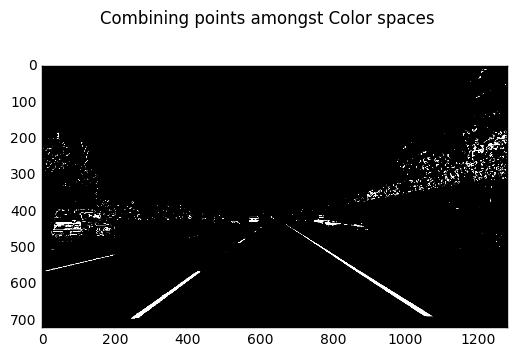

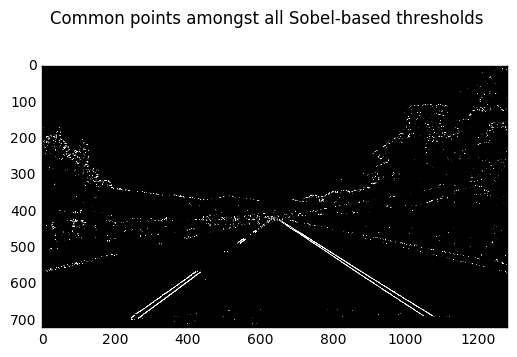

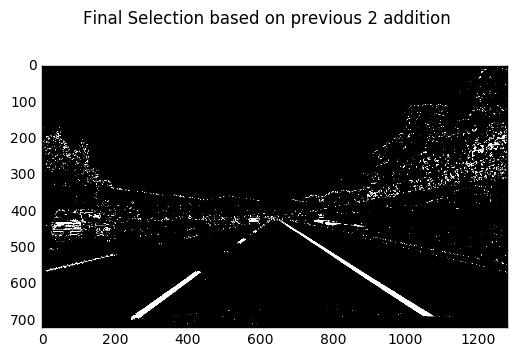

In [9]:
image8s1 = hls_select(image8c, (150, 225))
image8s2 = dir_thresh(image8c, 3, (0.7, 1.3))
image8s3 = mag_thresh(image8c, 3, (40, 250))
#image8s4 = absx_thresh(image8c, 80, 200)
#image8s5 = absy_thresh(image8c, 50, 250)
image8s6 = color_select(image8c, 200, 200)

image8sp1 = np.zeros_like(image8s2)
image8sp1 [((image8s1 == 1) | (image8s6 == 1))] = 1

image8sp2 = np.zeros_like(image8s2)
image8sp2 [(image8s2 == 1) & ((image8s3 == 1))] = 1 #& (image8s4 == 1) & (image8s5 == 1)

image8s = np.zeros_like(image8s2)
image8s [(image8sp1 == 1) | (image8sp2 == 1)] = 1

image = plt.imshow(image8s1, cmap='gray')
plt.suptitle('Saturation selection from HLS space', fontsize=12)
plt.show()
plt.imshow(image8s6, cmap='gray')
plt.suptitle('Yellow selection from RGB space', fontsize=12)
plt.show()

plt.imshow(image8s2, cmap='gray')
plt.suptitle('Direction threshold using Sobel', fontsize=12)
plt.show()
plt.imshow(image8s3, cmap='gray')
plt.suptitle('Magnitude threshold using Sobel', fontsize=12)
plt.show()
#plt.imshow(image8s4, cmap='gray')
#plt.suptitle('X direction threshold using Sobel', fontsize=12)
#plt.show()
#plt.imshow(image8s5, cmap='gray')
#plt.suptitle('Y direction threshold using Sobel', fontsize=12)
#plt.show()

plt.imshow(image8sp1, cmap='gray')
plt.suptitle('Combining points amongst Color spaces', fontsize=12)
plt.show()
plt.imshow(image8sp2, cmap='gray')
plt.suptitle('Common points amongst all Sobel-based thresholds', fontsize=12)
plt.show()

plt.imshow(image8s, cmap='gray')
plt.suptitle('Final Selection based on previous 2 addition', fontsize=12)
plt.show()

    Part 6: Warping lane - selecting points and calculating rotation matrix

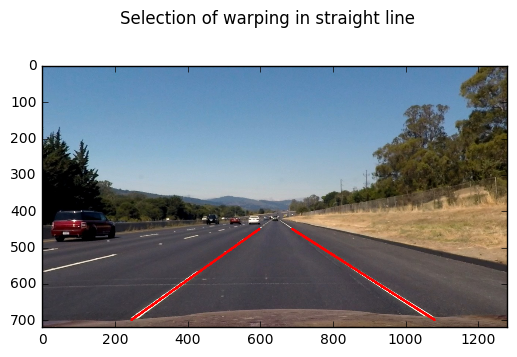

In [10]:
imagetest = image8c.copy()
rectangle = cv2.line(imagetest,(245,700),(597,450),(255,0,0),5)
rectangle = cv2.line(imagetest,(1078,700),(687,450),(255,0,0),5)
plt.imshow(imagetest)
plt.suptitle('Selection of warping in straight line', fontsize=12)
plt.show()

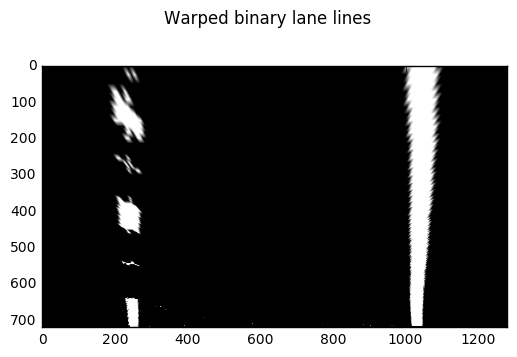

In [11]:
src = np.float32([[245,700],[597,450],[687,450],[1078,700]])
dst = np.float32([[250,720],[250,0],[1030,0],[1030,720]])
M = rotmat(src, dst)
out = unwrap(image8s, M)

plt.imshow(out, cmap='gray')
plt.suptitle('Warped binary lane lines', fontsize=12)
plt.show()

        Part 7: Sliding window search

In [12]:
from ipykernel import kernelapp as app

binary_warped=np.zeros_like(out)
binary_warped[(out>0)]=1

histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx_current = leftx_base
rightx_current = rightx_base
margin = 100
minpix = 50
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 


left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

/home/sagar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


    Part 7.5: Visualize the Polynomial fit

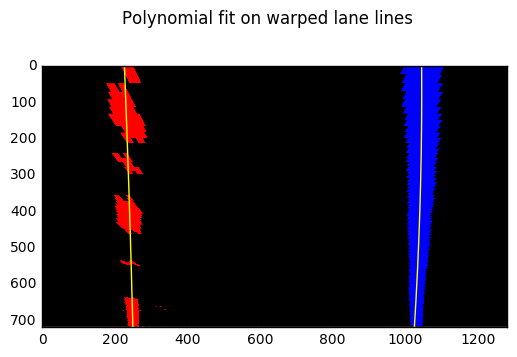

In [13]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img=np.zeros_like(image8c)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.suptitle('Polynomial fit on warped lane lines', fontsize=12)
plt.show()

    Part 7.6: Reverse check the lane shape to verify wrap

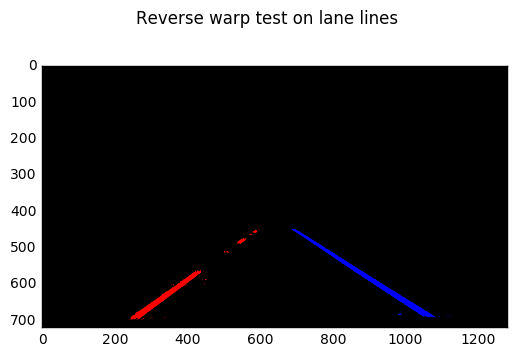

In [14]:
dst2 = np.float32([[245,700],[597,450],[687,450],[1078,700]])
src2 = np.float32([[250,720],[250,0],[1030,0],[1030,720]])
Minv = rotmat(src2, dst2)
out = unwrap(out_img, Minv)
        
plt.imshow(out)
plt.suptitle('Reverse warp test on lane lines', fontsize=12)
plt.show()

    Part 8: Find turning radius in pixel

In [15]:
y_eval = 720
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

48775.6836583 10495.3392128


    Part 8.5: Find turning radius in meters

In [16]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
print(left_curverad, 'm', right_curverad, 'm')

16006.0568379 m 3427.5681052 m


        Part 9: Finding offset in centimeters

In [17]:
leftdist = 640 - left_fitx[719]
rightdist = right_fitx[719] - 640
if leftdist>rightdist:
    offside = "right"
    offset = (leftdist - rightdist)*370/700
else:
    offside = "left"
    offset = (rightdist - leftdist)*370/700
print (offset,"cm.")

3.09220469456 cm.


    Part 10: Putting everything together 

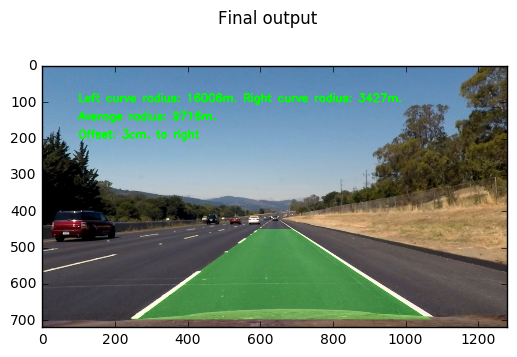

In [18]:
warp_zero = np.zeros_like(image8s).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
dst2 = np.float32([[245,700],[597,450],[687,450],[1078,700]])
src2 = np.float32([[250,720],[250,0],[1030,0],[1030,720]])
Minv = rotmat(src2, dst2)
newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720)) 
result = cv2.addWeighted(image8c, 1, newwarp, 0.3, 0)

text = "Left curve radius: " + str(int(left_curverad)) + "m. Right curve radius: " + str(int(right_curverad)) + "m."
cv2.putText(result,text, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

text1 = "Average radius: " + str(int((left_curverad+right_curverad)/2)) + "m."
cv2.putText(result,text1, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

text2 = "Offset: " + str(int(offset)) + "cm. to " + offside
cv2.putText(result,text2, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

plt.imshow(result)
plt.suptitle('Final output', fontsize=12)
plt.show()

    Part 11: Video Pipeline (same as Parts 4 to 10)

In [5]:
def process_image(img):
    imagec = undistort(img, mtx, dist)
    images1 = hls_select(imagec, (150, 225))
    images2 = dir_thresh(imagec, 3, (0.7, 1.3))
    images3 = mag_thresh(imagec, 3, (40, 250))
    #images4 = absx_thresh(imagec, 40, 200)
    #images5 = absy_thresh(imagec, 50, 250)
    images6 = color_select(imagec, 200, 200)

    imagesp1 = np.zeros_like(images1)
    imagesp1 [((images1 == 1) | (images6 == 1))] = 1

    imagesp2 = np.zeros_like(images2)
    imagesp2 [(images2 == 1) & (images3 == 1)] = 1 #& (images4 == 1) & (images5 == 1))] = 1

    images = np.zeros_like(images2)
    images [(imagesp1 == 1) | (imagesp2 == 1)] = 1

    out = unwrap(images, M)
    
    binary_warped=np.zeros_like(out)
    binary_warped[(out>0)]=1
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if (leftx.any()!=0):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = save1
    
    if (rightx.any()!=0):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = save2
    
    global save1 
    save1 = left_fit
    global save2 
    save2 = right_fit
    
    
    global frameno
    global lf
    global rf
    
    frameno+=1
    if (frameno>10):
        
        lf[0][0] = (left_fit[0] + lf[1][0] + lf[2][0] + lf[3][0] + lf[4][0])/5
        lf[0][1] = (left_fit[1] + lf[1][1] + lf[2][1] + lf[3][1] + lf[4][1])/5
        lf[0][2] = (left_fit[2] + lf[1][2] + lf[2][2] + lf[3][2] + lf[4][2])/5
        
        rf[0][0] = (right_fit[0] + rf[1][0] + rf[2][0] + rf[3][0] + rf[4][0])/5
        rf[0][1] = (right_fit[1] + rf[1][1] + rf[2][1] + rf[3][1] + rf[4][1])/5
        rf[0][2] = (right_fit[2] + rf[1][2] + rf[2][2] + rf[3][2] + rf[4][2])/5
    else:
        lf[0][0] = left_fit[0] 
        lf[0][1] = left_fit[1]
        lf[0][2] = left_fit[2]
        
        rf[0][0] = right_fit[0] 
        rf[0][1] = right_fit[1]
        rf[0][2] = right_fit[2]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = lf[0][0]*ploty**2 + lf[0][1]*ploty + lf[0][2]
    right_fitx = rf[0][0]*ploty**2 + rf[0][1]*ploty + rf[0][2]
    
    out_img=np.zeros_like(image8)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    y_eval = 650
    
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 


    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    leftdist = 640 - left_fitx[719]
    rightdist = right_fitx[719] - 640
    if leftdist>rightdist:
        offside = "right"
        offset = (leftdist - rightdist)*370/700
    else:
        offside = "left"
        offset = (rightdist - leftdist)*370/700
    
    warp_zero = np.zeros_like(images).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720)) 
    result = cv2.addWeighted(imagec, 1, newwarp, 0.3, 0)
    
    text = "Left curve radius: " + str(int(left_curverad)) + "m. Right curve radius: " + str(int(right_curverad)) + "m."
    cv2.putText(result,text, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

    text1 = "Average radius: " + str(int((left_curverad+right_curverad)/2)) + "m."
    cv2.putText(result,text1, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

    text2 = "Offset: " + str(int(offset)) + "cm. to " + offside
    cv2.putText(result,text2, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
    
    
    lf[4][:] = lf[3]
    lf[3][:] = lf[2]    
    lf[2][:] = lf[1]
    lf[1][:] = left_fit

    rf[4][:] = rf[3]  
    rf[3][:] = rf[2]
    rf[2][:] = rf[1]
    rf[1][:] = right_fit
    
    return result

<ipython-input-5-b28aa6afb7a6>:78: SyntaxWarning: name 'save1' is used prior to global declaration
  global save1
<ipython-input-5-b28aa6afb7a6>:80: SyntaxWarning: name 'save2' is used prior to global declaration
  global save2


    Part 13: Test images output code

/home/sagar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


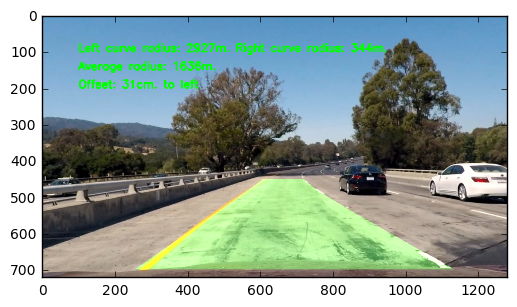

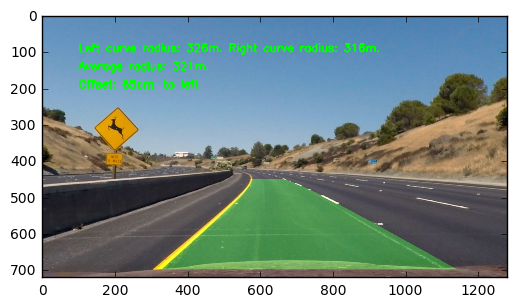

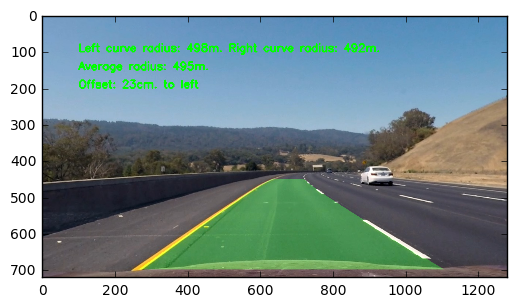

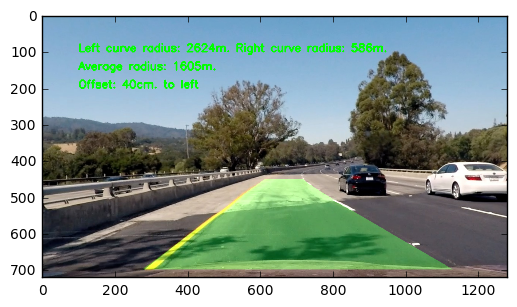

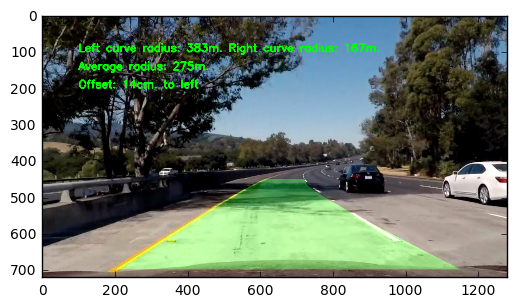

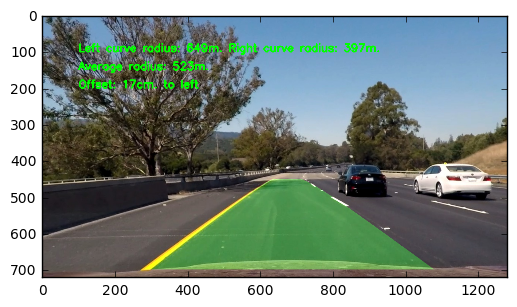

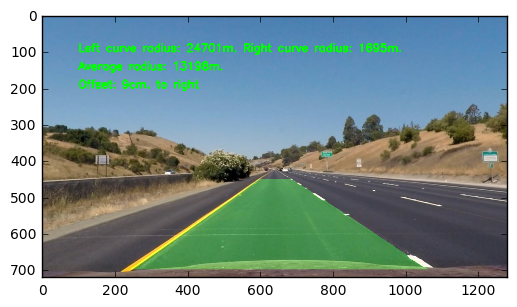

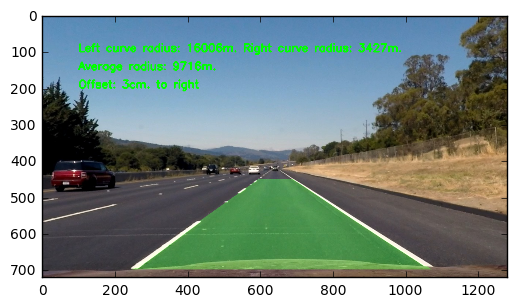

In [20]:
frameno=0
lf=([0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0])
rf=([0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0])

i1 = process_image(image1)
plt.imshow(i1)
plt.show()
i1 = process_image(image2)
plt.imshow(i1)
plt.show()
i1 = process_image(image3)
plt.imshow(i1)
plt.show()
i1 = process_image(image4)
plt.imshow(i1)
plt.show()
i1 = process_image(image5)
plt.imshow(i1)
plt.show()
i1 = process_image(image6)
plt.imshow(i1)
plt.show()
i1 = process_image(image7)
plt.imshow(i1)
plt.show()
i1 = process_image(image8)
plt.imshow(i1)
plt.show()

    Part 13: Video output code

In [7]:
from moviepy.editor import VideoFileClip

mtx, dist = calibrate()
src = np.float32([[245,700],[597,450],[687,450],[1078,700]])
dst = np.float32([[250,720],[250,0],[1030,0],[1030,720]])
M = rotmat(src, dst)

dst2 = np.float32([[245,700],[597,450],[687,450],[1078,700]])
src2 = np.float32([[250,720],[250,0],[1030,0],[1030,720]])
Minv = rotmat(src2, dst2)

frameno=0
lf=([0.0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0])
rf=([0.0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0])

lane_output = 'testout.mp4'
clip1 = VideoFileClip("test.mp4")
lane_clip = clip1.fl_image(process_image)
%time lane_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video testout.mp4
[MoviePy] Writing video testout.mp4


100%|██████████| 2836/2836 [15:34<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testout.mp4 

CPU times: user 46min 18s, sys: 1min 39s, total: 47min 58s
Wall time: 15min 36s


End of Project - Please check writeup attached